<a href="https://colab.research.google.com/github/georgepar/lt-asrtts/blob/main/Speech_Processing_for_Machine_Learning_Filter_banks_MFCCs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between

Source: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html




Speech processing plays an important role in any speech system whether its Automatic Speech Recognition (ASR) or speaker recognition or something else. Mel-Frequency Cepstral Coefficients (MFCCs) were very popular features for a long time; but more recently, filter banks are becoming increasingly popular. In this post, I will discuss filter banks and MFCCs and why are filter banks becoming increasingly popular.

Computing filter banks and MFCCs involve somewhat the same procedure, where in both cases filter banks are computed and with a few more extra steps MFCCs can be obtained. In a nutshell, a signal goes through a pre-emphasis filter; then gets sliced into (overlapping) frames and a window function is applied to each frame; afterwards, we do a Fourier transform on each frame (or more specifically a Short-Time Fourier Transform) and calculate the power spectrum; and subsequently compute the filter banks. To obtain MFCCs, a Discrete Cosine Transform (DCT) is applied to the filter banks retaining a number of the resulting coefficients while the rest are discarded. A final step in both cases, is mean normalization.

Setup
For this post, I used a 16-bit PCM wav file from [here](https://www.voiptroubleshooter.com/open_speech/american.html), called “OSR_us_000_0010_8k.wav”, which has a sampling frequency of 8000 Hz. The wav file is a clean speech signal comprising a single voice uttering some sentences with some pauses in-between. For simplicity, I used the first 3.5 seconds of the signal which corresponds roughly to the first sentence in the wav file.

I’ll be using Python 2.7.x, NumPy and SciPy. Some of the code used in this post is based on code available in this repository.

In [1]:
!wget https://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0010_8k.wav

--2024-03-08 21:33:41--  https://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0010_8k.wav
Resolving www.voiptroubleshooter.com (www.voiptroubleshooter.com)... 162.241.218.124
Connecting to www.voiptroubleshooter.com (www.voiptroubleshooter.com)|162.241.218.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538014 (525K) [audio/x-wav]
Saving to: ‘OSR_us_000_0010_8k.wav’

OSR_us_000_0010_8k. 100%[===================>] 525.40K  1.84MB/s    in 0.3s    

2024-03-08 21:33:42 (1.84 MB/s) - ‘OSR_us_000_0010_8k.wav’ saved [538014/538014]



In [4]:
!pip install numpy scipy matplotlib

In [99]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct

sample_rate, signal = scipy.io.wavfile.read('OSR_us_000_0010_8k.wav')  # File assumed to be in the same directory
signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds

The raw signal has the following form in the time domain:

In [15]:
import matplotlib.pyplot as plt

def plot_signal(sig):
  # Create a time array from the number of samples
  time = np.linspace(0, len(sig) / sample_rate, num=len(sig))

  # Plot the signal
  plt.figure(figsize=(10, 4))  # Set the figure size as needed
  plt.plot(time, sig, label='OSR_us_000_0010_8k.wav')
  plt.title('Signal in the Time Domain')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.grid(True)
  plt.show()

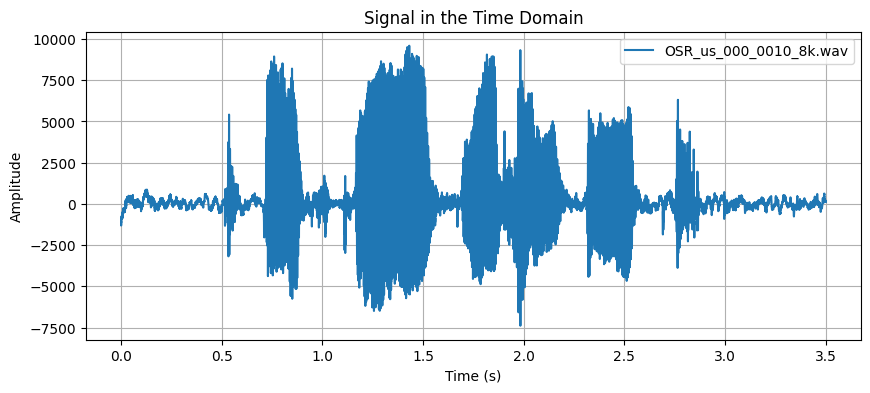

In [16]:
plot_signal(signal)

## Pre-Emphasis
The first step is to apply a pre-emphasis filter on the signal to amplify the high frequencies. A pre-emphasis filter is useful in several ways: (1) balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies, (2) avoid numerical problems during the Fourier transform operation and (3) may also improve the Signal-to-Noise Ratio (SNR).

The pre-emphasis filter can be applied to a signal x
 using the first order filter in the following equation:

$$ y(t) = x(t) - \alpha x(t-1)  $$

which can be easily implemented using the following line, where typical values for the filter coefficient (α
) are 0.95 or 0.97:

In [11]:
pre_emphasis = 0.97

emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

[Pre-emphasis has a modest effect in modern systems](https://www.quora.com/Why-is-pre-emphasis-i-e-passing-the-speech-signal-through-a-first-order-high-pass-filter-required-in-speech-processing-and-how-does-it-work/answer/Nickolay-Shmyrev?srid=e4nz&share=71ca3e28), mainly because most of the motivations for the pre-emphasis filter can be achieved using mean normalization (discussed later in this post) except for avoiding the Fourier transform numerical issues which should not be a problem in modern FFT implementations.

The signal after pre-emphasis has the following form in the time domain:

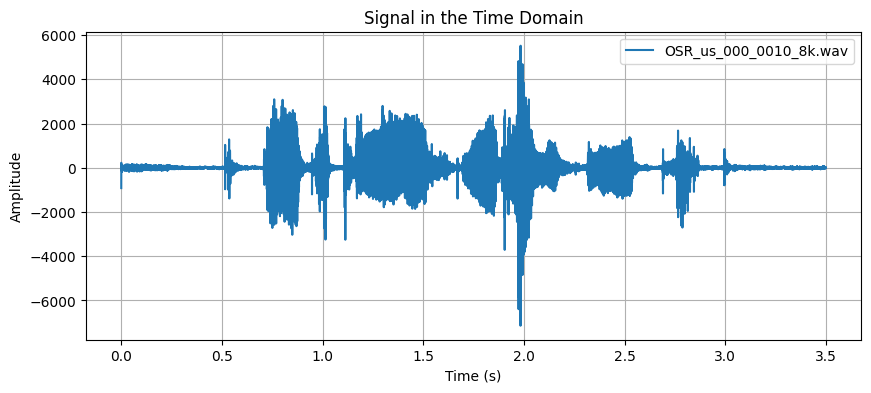

In [17]:
plot_signal(emphasized_signal)

## Framing


After pre-emphasis, we need to split the signal into short-time frames. The rationale behind this step is that frequencies in a signal change over time, so in most cases it doesn’t make sense to do the Fourier transform across the entire signal in that we would lose the frequency contours of the signal over time. To avoid that, we can safely assume that frequencies in a signal are stationary over a very short period of time. Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.

Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size and a 10 ms stride (15 ms overlap).

In [119]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

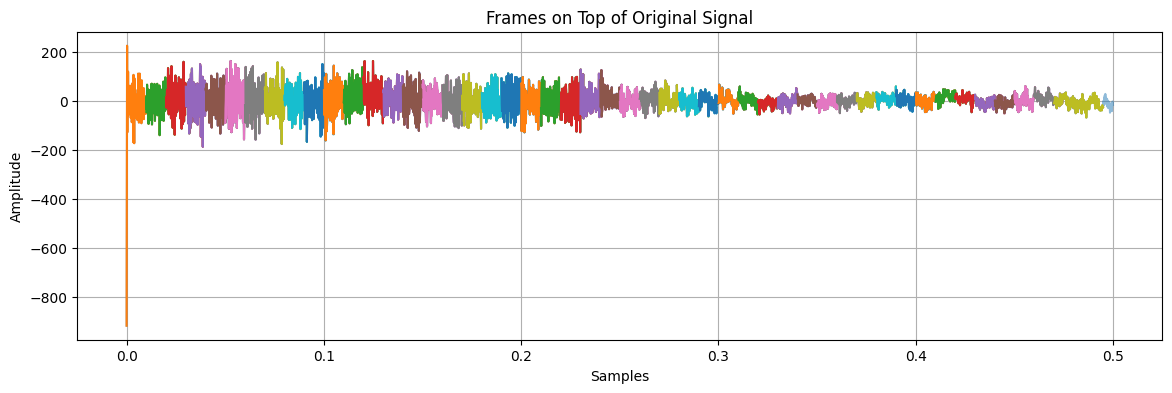

In [120]:
# Let's plot a subset of frames on top of the original signal.

def plot_frames(frames):
  sig = emphasized_signal[:4000]
  t = np.linspace(0, len(sig) / sample_rate, num=len(sig))

  plt.figure(figsize=(14, 4))

  # Plot the original signal
  plt.plot(t, sig, label='Original Signal', alpha=0.5)

  # Plot the first 5 frames with different colors on top of the original signal
  for i in range(48):
    j =  i
    plt.plot(t[indices[j, :].astype(np.int32, copy=False)], frames[j], label=f'Frame {j+1}')

  plt.title('Frames on Top of Original Signal')
  plt.xlabel('Samples')
  plt.ylabel('Amplitude')
  # plt.legend()
  plt.grid(True)
  plt.show()

plot_frames(frames)

## Window

After slicing the signal into frames, we apply a window function such as the Hamming window to each frame. A Hamming window has the following form:

$$ w[n] = 0.54 − 0.46 cos ( \frac{2πn}{N − 1} ) $$

where $0 \leq n \leq N - 1$ is the window length. Plotting the previous equation yields the following plot:

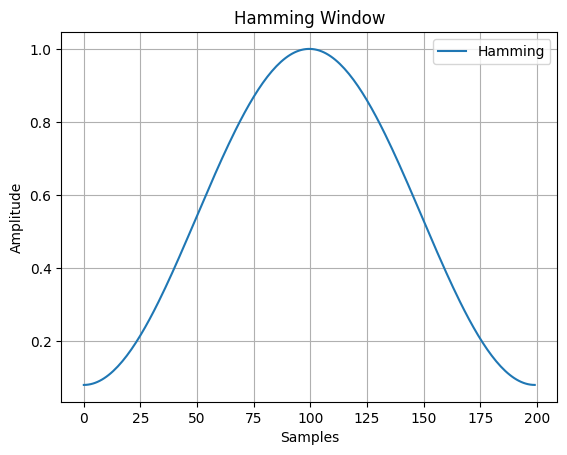

In [121]:
# Create a Hamming window
N = 200  # Number of samples
window = np.hamming(N)

# Plot the window
plt.plot(window, label='Hamming')
plt.title('Hamming Window')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

There are several reasons why we need to apply a window function to the frames, notably to counteract the assumption made by the FFT that the data is infinite and to reduce spectral leakage.

In [122]:
frames *= np.hamming(frame_length)

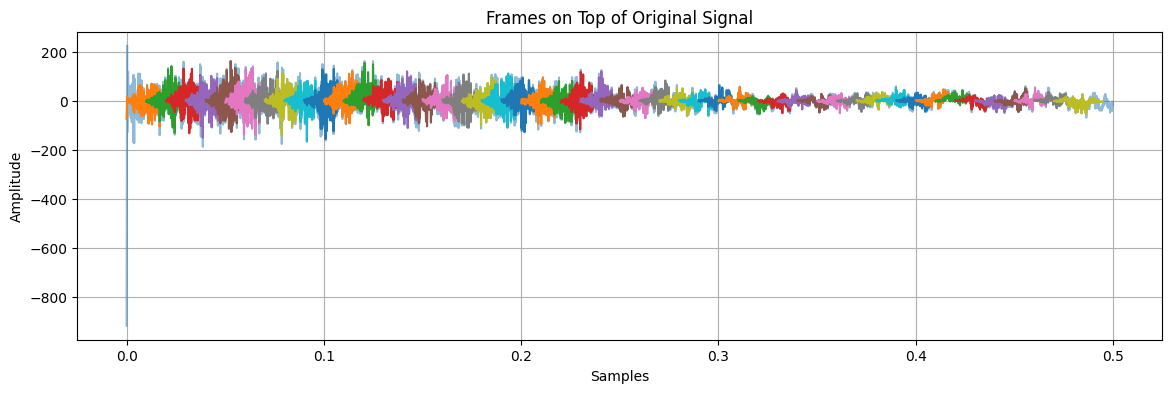

In [123]:
plot_frames(frames)

We can now do an $N$-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time Fourier-Transform (STFT), where $N$
 is typically 256 or 512, and then compute the power spectrum (periodogram) using the following equation:

 $$ P = \frac{|FFT(x_i)|^2}{N} $$

 where, $x_i$ is the $i$-th frame of signal $x$. This could be implemented with the following lines:

In [140]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

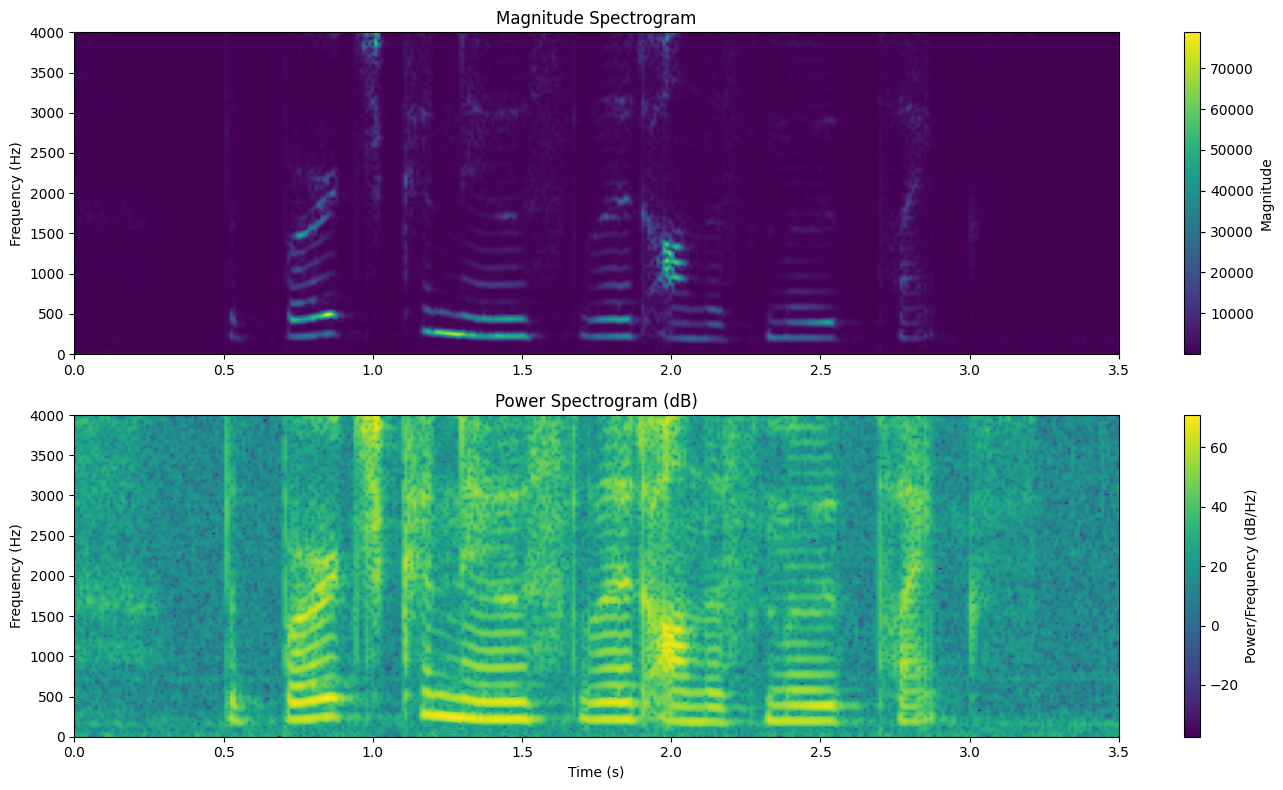

In [144]:
# To plot mag_frames and pow_frames as spectrograms, we will consider mag_frames and pow_frames to be 2D arrays where
# each row corresponds to a frame of the signal.

plt.figure(figsize=(14, 8))

# Plot the magnitude spectrogram
plt.subplot(2, 1, 1)
# create_spec_plot(mag_frames, 'Magnitude Spectrogram', 'Magnitude', 'Frequency (Hz)')
plt.imshow(mag_frames.T, aspect='auto', origin='lower', extent=[0, len(signal)/sample_rate, 0, sample_rate/2])
plt.title('Magnitude Spectrogram')
plt.ylabel('Frequency (Hz)')
plt.colorbar().set_label('Magnitude')

# Plot the power spectrogram
plt.subplot(2, 1, 2)
plt.imshow(10*np.log10(pow_frames.T), aspect='auto', origin='lower', extent=[0, len(signal)/sample_rate, 0, sample_rate/2])
plt.title('Power Spectrogram (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar().set_label('Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()


## Filter Banks

The final step to computing filter banks is applying triangular filters, typically 40 filters, on a Mel-scale to the power spectrum to extract frequency bands. The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies. We can convert between Hertz ($f$) and Mel ($m$) using the following equations:

$$ m = 2595 \log_{10} (1 + \frac{f}{700}) $$

$$ f = 700 (10^{m/2595} - 1) $$

Each filter in the filter bank is triangular having a response of 1 at the center frequency and decrease linearly towards 0 till it reaches the center frequencies of the two adjacent filters where the response is 0.

This can be modeled by the following equation (taken from [here](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)):


$$H_m(k) =  \begin{cases}  \hfill 0  \hfill  & k < f(m - 1) \\
      \hfill \dfrac{k - f(m - 1)}{f(m) - f(m - 1)}  \hfill  & f(m - 1) \leq k < f(m) \\
      \hfill 1                                      \hfill & k = f(m) \\
      \hfill \dfrac{f(m + 1) - k}{f(m + 1) - f(m)}  \hfill & f(m) < k \leq f(m + 1) \\
      \hfill 0                                      \hfill & k > f(m + 1)
  \end{cases}$$

In [126]:
# Number of filters
nfilt = 40

# Calculate Mel filter bank using the provided formulas
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

# Ensuring the 'bin' array is of type 'int' for indexing
bin = bin.astype(int)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = bin[m - 1]   # left
    f_m = bin[m]             # center
    f_m_plus = bin[m + 1]    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])


filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

The filter banks are plotted in the following figure

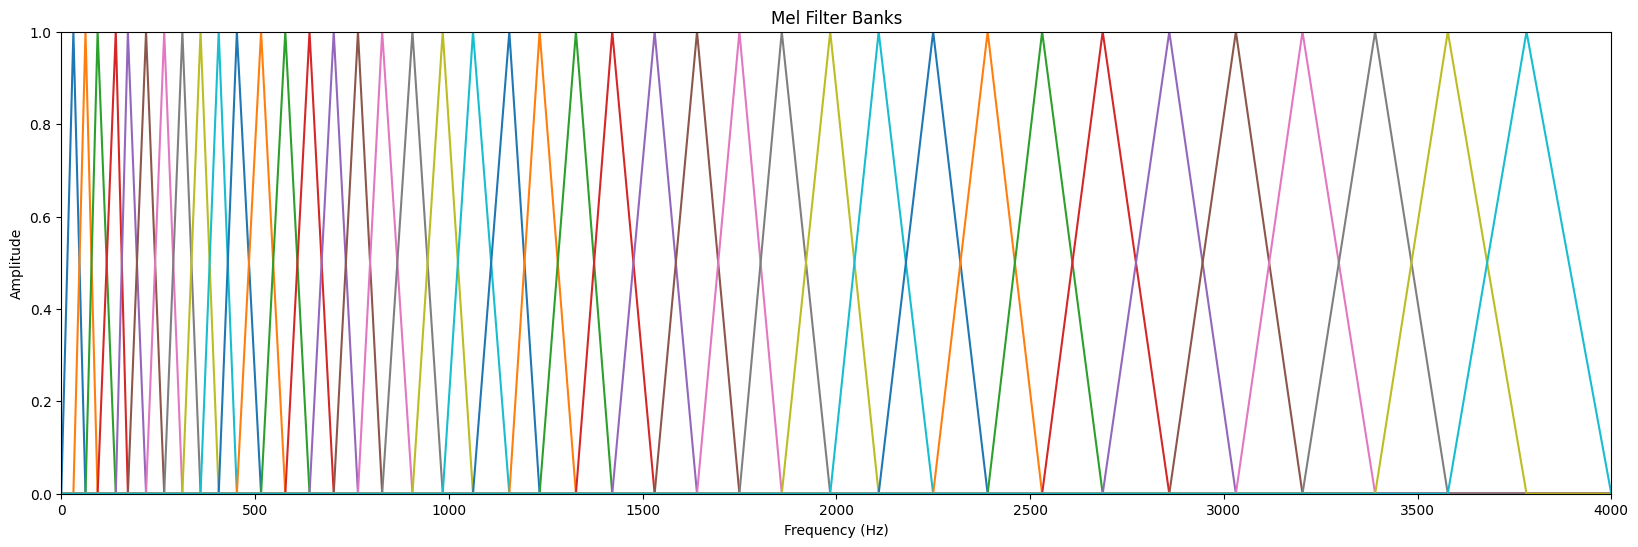

In [127]:
# Plot the filter banks
plt.figure(figsize=(20, 6))
# Only plotting the non-zero parts of the filter banks
for n in range(nfilt):
    plt.plot(np.linspace(0, sample_rate / 2, int(np.floor(NFFT / 2 + 1))), fbank[n])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Mel Filter Banks')
plt.xlim(0, sample_rate / 2)
plt.ylim(0, np.max(fbank))
plt.show()

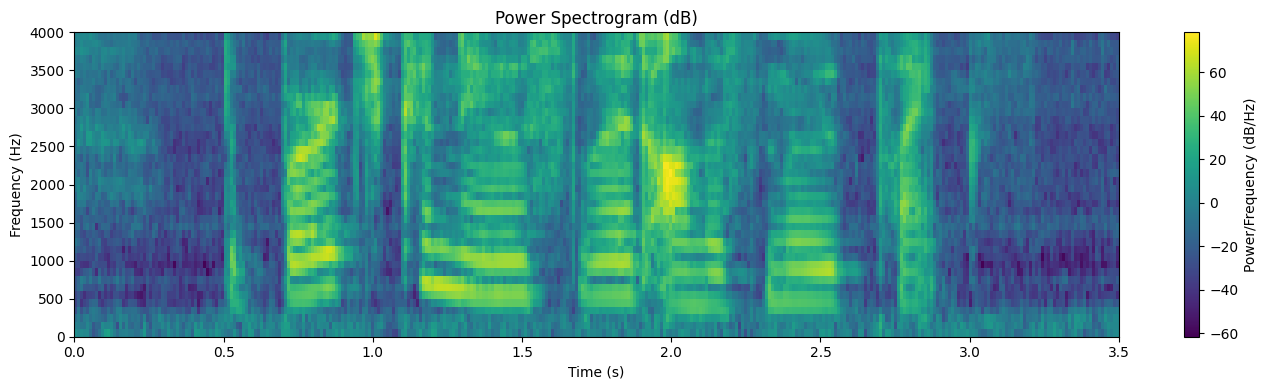

In [146]:
plt.figure(figsize=(14, 4))

plt.imshow(filter_banks.T, aspect='auto', origin='lower', extent=[0, len(signal)/sample_rate, 0, sample_rate/2])
plt.title('Power Spectrogram (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar().set_label('Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()

If the Mel-scaled filter banks were the desired features then we can skip to mean normalization.

## Mel-frequency Cepstral Coefficients (MFCCs)

It turns out that filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks. Typically, for Automatic Speech Recognition (ASR), the resulting cepstral coefficients 2-13 are retained and the rest are discarded. The [reasons for discarding the other coefficients](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) is that they represent fast changes in the filter bank coefficients and these fine details don’t contribute to Automatic Speech Recognition (ASR).

In [137]:
num_ceps = 12
cep_lifter = 30
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

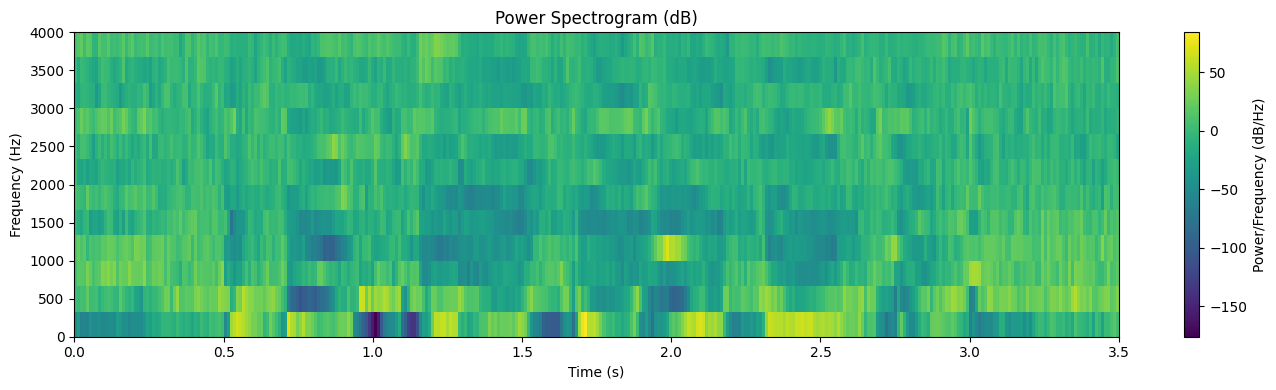

In [138]:
plt.figure(figsize=(14, 4))

plt.imshow(mfcc.T, aspect='auto', origin='lower', extent=[0, len(signal)/sample_rate, 0, sample_rate/2])
plt.title('Power Spectrogram (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar().set_label('Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()

One may apply sinusoidal liftering1 to the MFCCs to de-emphasize higher MFCCs which has been claimed to improve speech recognition in noisy signals.

In [135]:
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(numpy.pi * n / cep_lifter)
mfcc *= lift

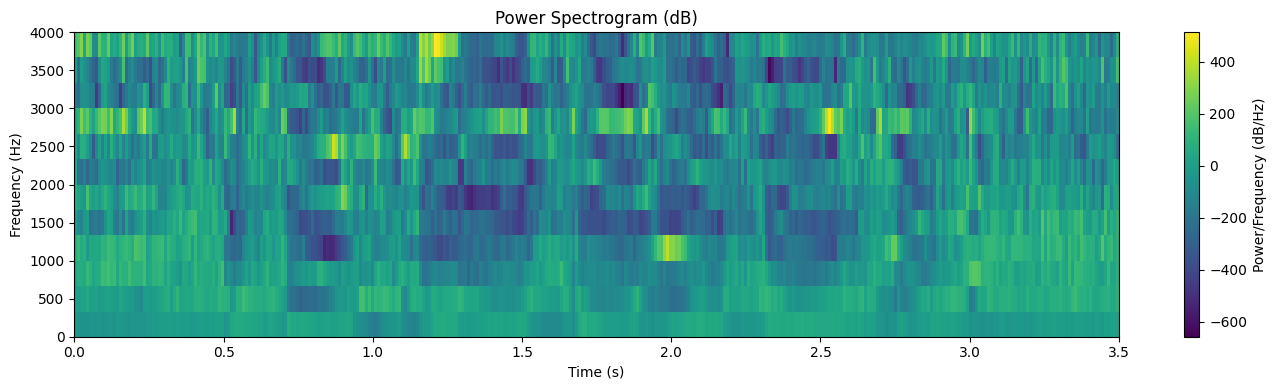

In [136]:
plt.figure(figsize=(14, 4))

plt.imshow(mfcc.T, aspect='auto', origin='lower', extent=[0, len(signal)/sample_rate, 0, sample_rate/2])
plt.title('Power Spectrogram (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar().set_label('Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()

## Mean Normalization
As previously mentioned, to balance the spectrum and improve the Signal-to-Noise (SNR), we can simply subtract the mean of each coefficient from all frames.

In [139]:
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

The mean-normalized filter banks:

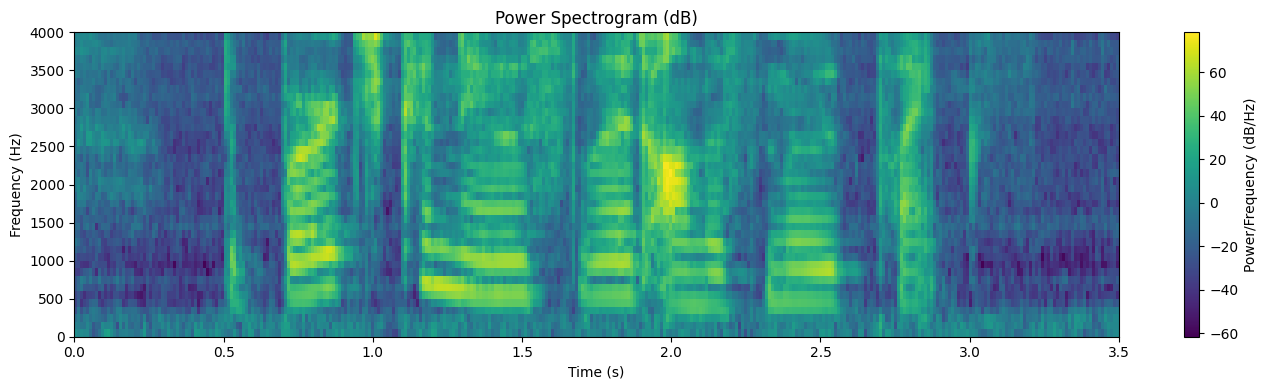

In [145]:
plt.figure(figsize=(14, 4))

plt.imshow(filter_banks.T, aspect='auto', origin='lower', extent=[0, len(signal)/sample_rate, 0, sample_rate/2])
plt.title('Power Spectrogram (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar().set_label('Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()

and similarly for MFCCs:

In [147]:
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

The mean-normalized MFCCs:

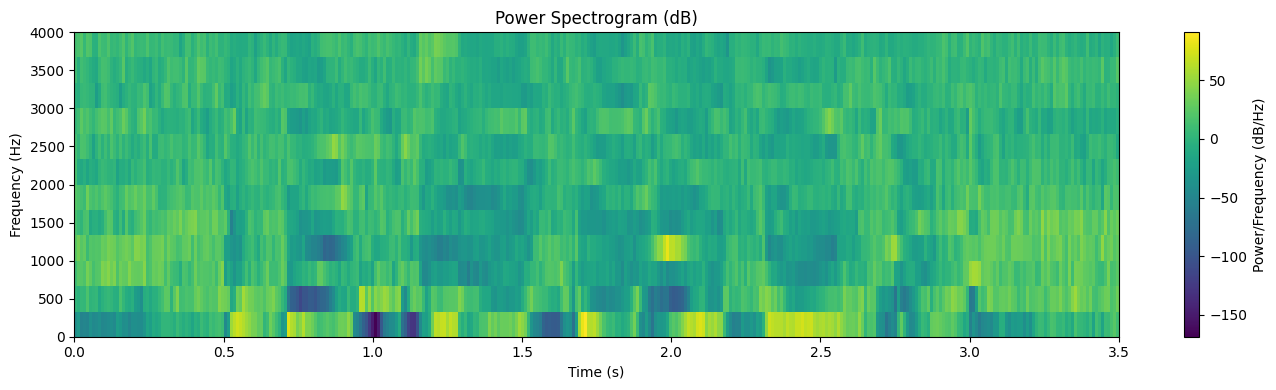

In [148]:
plt.figure(figsize=(14, 4))

plt.imshow(mfcc.T, aspect='auto', origin='lower', extent=[0, len(signal)/sample_rate, 0, sample_rate/2])
plt.title('Power Spectrogram (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar().set_label('Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()

## Filter Banks vs MFCCs

To this point, the steps to compute filter banks and MFCCs were discussed in terms of their motivations and implementations. It is interesting to note that all steps needed to compute filter banks were motivated by the nature of the speech signal and the human perception of such signals. On the contrary, the extra steps needed to compute MFCCs were motivated by the limitation of some machine learning algorithms. The Discrete Cosine Transform (DCT) was needed to decorrelate filter bank coefficients, a process also referred to as whitening. In particular, MFCCs were very popular when Gaussian Mixture Models - Hidden Markov Models (GMMs-HMMs) were very popular and together, MFCCs and GMMs-HMMs co-evolved to be the standard way of doing Automatic Speech Recognition (ASR)2. With the advent of Deep Learning in speech systems, one might question if MFCCs are still the right choice given that deep neural networks are less susceptible to highly correlated input and therefore the Discrete Cosine Transform (DCT) is no longer a necessary step. It is beneficial to note that Discrete Cosine Transform (DCT) is a linear transformation, and therefore undesirable as it discards some information in speech signals which are highly non-linear.

It is sensible to question if the Fourier Transform is a necessary operation. Given that the Fourier Transform itself is also a linear operation, it might be beneficial to ignore it and attempt to learn directly from the signal in the time domain. Indeed, some recent work has already attempted this and positive results were reported. However, the Fourier transform operation is a difficult operation to learn and may arguably increase the amount of data and model complexity needed to achieve the same performance. Moreover, in doing Short-Time Fourier Transform (STFT), we’ve assumed the signal to be stationary within this short time and therefore the linearity of the Fourier transform would not pose a critical problem.



## Conclusion

In this post, we’ve explored the procedure to compute Mel-scaled filter banks and Mel-Frequency Cepstrum Coefficients (MFCCs). The motivations and implementation of each step in the procedure were discussed. We’ve also argued the reasons behind the increasing popularity of filter banks compared to MFCCs.

tl;dr: Use Mel-scaled filter banks if the machine learning algorithm is not susceptible to highly correlated input. Use MFCCs if the machine learning algorithm is susceptible to correlated input.

1. Liftering is filtering in the cepstral domain. Note the abuse of notation in spectral and cepstral with filtering and liftering respectively. ↩

2. An excellent discussion on this topic is in [this thesis](https://tspace.library.utoronto.ca/bitstream/1807/44123/1/Mohamed_Abdel-rahman_201406_PhD_thesis.pdf)